In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Spot Check Algorithm - helps with finding appropriate models

In [ ]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
 
 
 # create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 5, 10]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 10)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
	degree = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c, class_weight = 'balanced')
		models['svml'+str(c)] = SVC(kernel='linear', C= c, class_weight = 'balanced')
		for d in degree:
			models['svmp'+str(c) + str(d)] = SVC(kernel='poly', C=c, degree=d, class_weight = 'balanced')
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# no transforms pipeline
def pipeline_none(model):
	return model
 
# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X_train, Y_train, model, folds, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = cross_val_score(pipeline, X_train, Y_train, scoring=metric, cv=folds, n_jobs=-1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X_train, Y_train, model, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X_train, Y_train, model, folds, metric, pipe_func)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X_train, Y_train, models, pipe_funcs, folds=4, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X_train, Y_train, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=20):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 

# get model list
models = define_models()
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X_train, Y_train, models, pipelines)
# summarize results
summarize_results(results)

Defined 513 models
>0logistic: 0.669 (+/-0.054)
>1logistic: 0.690 (+/-0.025)
>2logistic: 0.690 (+/-0.025)
>3logistic: 0.690 (+/-0.025)
>0ridge-0.001: 0.644 (+/-0.057)
>1ridge-0.001: 0.644 (+/-0.057)
>2ridge-0.001: 0.644 (+/-0.057)
>3ridge-0.001: 0.644 (+/-0.057)
>0ridge-0.005: 0.644 (+/-0.057)
>1ridge-0.005: 0.644 (+/-0.057)
>2ridge-0.005: 0.644 (+/-0.057)
>3ridge-0.005: 0.644 (+/-0.057)
>0ridge-0.01: 0.644 (+/-0.057)
>1ridge-0.01: 0.644 (+/-0.057)
>2ridge-0.01: 0.644 (+/-0.057)
>3ridge-0.01: 0.644 (+/-0.057)
>0ridge-0.05: 0.644 (+/-0.057)
>1ridge-0.05: 0.644 (+/-0.057)
>2ridge-0.05: 0.644 (+/-0.057)
>3ridge-0.05: 0.644 (+/-0.057)
>0ridge-0.1: 0.644 (+/-0.057)
>1ridge-0.1: 0.644 (+/-0.057)
>2ridge-0.1: 0.644 (+/-0.057)
>3ridge-0.1: 0.644 (+/-0.057)
>0ridge-0.2: 0.644 (+/-0.057)
>1ridge-0.2: 0.644 (+/-0.057)
>2ridge-0.2: 0.644 (+/-0.057)
>3ridge-0.2: 0.644 (+/-0.057)
>0ridge-0.3: 0.644 (+/-0.057)
>1ridge-0.3: 0.644 (+/-0.057)
>2ridge-0.3: 0.644 (+/-0.057)
>3ridge-0.3: 0.644 (+/-0.057)
>

Import files below:

1. data1 = stepcount + demographic data in discrete categories
2. d1 = demographic data in discrete categories
3. data2 = stepcount + demographic data as continuous variables
4. d2 = demographic data as a continuous variable

In [5]:
file1 = 'no_band_steps.xlsx'
data1 = pd.read_excel(file1)
data1 = data1.set_index('studyID')

d1 = data1.drop(columns = 'Steps')

file2 = 'band_steps.xlsx'
data2 = pd.read_excel(file2)
data2 = data2.set_index('studyID')

d2 = data2.drop(columns = 'Steps_band')


Demographic: No Band

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
d1_train_acc = []
d1_test_acc = []
d1_roc = []
d1_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(d1, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale', C= 20)
    clf.fit(X_train, Y_train)
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    d1_train_acc.append(svm_train_acc)
    d1_test_acc.append(svm_test_acc)
    d1_roc.append(roc)
    d1_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)

print('Mean Training Accuracy:', mean(d1_train_acc)) 
print('Mean Test Accuracy:', mean(d1_test_acc)) 
print('Mean ROC AUC score:', mean(d1_roc))
print('Mean PR AUC score:', mean(d1_pr))

Random State:  100
Training Accuracy: 0.8666666666666667
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.625
Random State:  122
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.4166666666666667
ROC AUC SCORE: 0.375
PR AUC SCORE: 0.3
Random State:  200
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  300
Training Accuracy: 0.7333333333333333
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6285714285714286
PR AUC SCORE: 0.5166666666666666
Random State:  368
Training Accuracy: 0.8
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.4
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.8
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.25
Random State:  500
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5833333333333334
PR AUC SCORE: 0.5555555555555556
Random State:  600
Training Accuracy:

Demographic: Band

In [59]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
d2_train_acc = []
d2_test_acc = []
d2_roc = []
d2_pr = []


for i in random_state :
    
    train_df, test_df = train_test_split(d2, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)  

    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    d2_train_acc.append(svm_train_acc)
    d2_test_acc.append(svm_test_acc)
    d2_roc.append(roc)
    d2_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)



print('Mean Training Accuracy:', mean(d2_train_acc)) 
print('Mean Test Accuracy:', mean(d2_test_acc)) 
print('Mean ROC AUC score:', mean(d2_roc))
print('Mean PR AUC score:', mean(d2_pr))

Random State:  100
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.6666666666666667
Random State:  122
Training Accuracy: 0.8
Test Accuracy: 0.75
ROC AUC SCORE: 0.625
PR AUC SCORE: 0.5
Random State:  200
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.4166666666666667
Random State:  300
Training Accuracy: 0.8
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6285714285714286
PR AUC SCORE: 0.5166666666666666
Random State:  368
Training Accuracy: 0.7555555555555555
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.4444444444444444
PR AUC SCORE: 0.25
Random State:  500
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.5
Random State:  600
Training Accuracy: 0.75555555555555

Steps + Demographic: No Band

In [60]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
data1_train_acc = []
data1_test_acc = []
data1_roc = []
data1_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(data1, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)  
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')

    
    data1_train_acc.append(svm_train_acc)
    data1_test_acc.append(svm_test_acc)
    data1_roc.append(roc)
    data1_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(data1_train_acc)) 
print('Mean Test Accuracy:', mean(data1_test_acc))
print('Mean ROC AUC score:', mean(data1_roc))
print('Mean PR AUC score:', mean(data1_pr))

Random State:  100
Training Accuracy: 0.6666666666666666
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5833333333333334
PR AUC SCORE: 0.55
Random State:  122
Training Accuracy: 0.6444444444444445
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.5625
PR AUC SCORE: 0.375
Random State:  200
Training Accuracy: 0.6222222222222222
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  300
Training Accuracy: 0.7333333333333333
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  368
Training Accuracy: 0.6888888888888889
Test Accuracy: 0.4166666666666667
ROC AUC SCORE: 0.25
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.5555555555555556
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.7222222222222222
PR AUC SCORE: 0.375
Random State:  500
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5833333333333334
PR AUC SCORE: 0.55
Random State:  600
Training Acc

Steps + Demographic: Band

In [61]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
data2_train_acc = []
data2_test_acc = []
data2_roc = []
data2_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(data2, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')

    
    data2_train_acc.append(svm_train_acc)
    data2_test_acc.append(svm_test_acc)
    data2_roc.append(roc)
    data2_pr.append(pr)

    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)



print('Mean Training Accuracy:', mean(data2_train_acc)) 
print('Mean Test Accuracy:', mean(data2_test_acc)) 
print('Mean ROC AUC score:', mean(data2_roc))
print('Mean PR AUC score:', mean(data2_pr))

Random State:  100
Training Accuracy: 0.8
Test Accuracy: 0.75
ROC AUC SCORE: 0.75
PR AUC SCORE: 0.75
Random State:  122
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.75
ROC AUC SCORE: 0.625
PR AUC SCORE: 0.5
Random State:  200
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5285714285714286
PR AUC SCORE: 0.43333333333333335
Random State:  300
Training Accuracy: 0.8
Test Accuracy: 0.75
ROC AUC SCORE: 0.7
PR AUC SCORE: 0.65
Random State:  368
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.5
ROC AUC SCORE: 0.3
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.8
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.5
Random State:  500
Training Accuracy: 0.8666666666666667
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5833333333333334
PR AUC SCORE: 0.55
Random State:  600
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.75
ROC AUC SCORE: 0.75
PR AUC SCORE: 0.5333333333

Important files below:

1. no_band_final = KEGG + Demographic + stepcount data as continuous variables
2. norm_no_band_final = KEGG + Demographic + stepcount data as continuous variables
3. band_final = KEGG + Demographic + stepcount data as discrete variables
4. norm_band_final = KEGG + Demographic + stepcount data as discrete variables

In [23]:
no_band_final = pd.read_excel('final_no_band.xlsx')
no_band_final = no_band_final.set_index('studyID')

norm_no_band_final = pd.read_excel('norm_final_no_band.xlsx')
norm_no_band_final = norm_no_band_final.set_index('studyID')

band_final = pd.read_excel('final_band.xlsx')
band_final = band_final.set_index('studyID')

norm_band_final = pd.read_excel('norm_final_band.xlsx')
norm_band_final = norm_band_final.set_index('studyID')

KEGG + Demographic: No Band

In [62]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
no_band_train_acc = []
no_band_test_acc = []
no_band_roc = []
no_band_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(no_band_final, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']
        
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train) 
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    no_band_train_acc.append(svm_train_acc)
    no_band_test_acc.append(svm_test_acc)
    no_band_roc.append(roc)
    no_band_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(no_band_train_acc)) 
print('Mean Test Accuracy:', mean(no_band_test_acc)) 
print('Mean ROC AUC score:', mean(no_band_roc))
print('Mean PR AUC score:', mean(no_band_pr))

Random State:  100
Training Accuracy: 1.0
Test Accuracy: 0.75
ROC AUC SCORE: 0.75
PR AUC SCORE: 0.7
Random State:  122
Training Accuracy: 1.0
Test Accuracy: 0.9166666666666666
ROC AUC SCORE: 0.875
PR AUC SCORE: 0.8333333333333334
Random State:  200
Training Accuracy: 1.0
Test Accuracy: 0.75
ROC AUC SCORE: 0.7285714285714286
PR AUC SCORE: 0.6166666666666667
Random State:  300
Training Accuracy: 1.0
Test Accuracy: 0.75
ROC AUC SCORE: 0.7285714285714286
PR AUC SCORE: 0.6166666666666667
Random State:  368
Training Accuracy: 1.0
Test Accuracy: 0.4166666666666667
ROC AUC SCORE: 0.65
PR AUC SCORE: 0.2222222222222222
Random State:  400
Training Accuracy: 1.0
Test Accuracy: 0.75
ROC AUC SCORE: 0.7571428571428572
PR AUC SCORE: 0.6166666666666667
Random State:  500
Training Accuracy: 1.0
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.75
PR AUC SCORE: 0.5
Random State:  600
Training Accuracy: 1.0
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.6111111111111112
PR AUC SCORE: 0.30555555555555

KEGG + Demographic: No Band,
Normalized

In [63]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
norm_no_band_train_acc = []
norm_no_band_test_acc = []
norm_no_band_roc = []
norm_no_band_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(norm_no_band_final, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)  

    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    norm_no_band_train_acc.append(svm_train_acc)
    norm_no_band_test_acc.append(svm_test_acc)
    norm_no_band_roc.append(roc)
    norm_no_band_pr.append(pr)

    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(norm_no_band_train_acc)) 
print('Mean Test Accuracy:', mean(norm_no_band_test_acc)) 
print('Mean ROC AUC score:', mean(norm_no_band_roc))
print('Mean PR AUC score:', mean(norm_no_band_pr))

Random State:  100
Training Accuracy: 0.75
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.5
Random State:  122
Training Accuracy: 0.7727272727272727
Test Accuracy: 0.75
ROC AUC SCORE: 0.625
PR AUC SCORE: 0.5
Random State:  200
Training Accuracy: 0.8409090909090909
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  300
Training Accuracy: 0.7045454545454546
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.4166666666666667
Random State:  368
Training Accuracy: 0.7727272727272727
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.7000000000000001
PR AUC SCORE: 0.3333333333333333
Random State:  400
Training Accuracy: 0.75
Test Accuracy: 0.5
ROC AUC SCORE: 0.4285714285714286
PR AUC SCORE: 0.4166666666666667
Random State:  500
Training Accuracy: 0.8181818181818182
Test Accuracy: 0.4166666666666667
ROC AUC SCORE: 0.375
PR AUC SCORE: 0.3
Random State:  600
Training Accuracy: 0.7954545454545454
Test Accuracy: 0.6666666666666666
ROC A

KEGG + Demographic: Band

In [65]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
band_train_acc = []
band_test_acc = []
band_roc = []
band_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(band_final, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)  
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    band_train_acc.append(svm_train_acc)
    band_test_acc.append(svm_test_acc)
    band_roc.append(roc)
    band_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(band_train_acc)) 
print('Mean Test Accuracy:', mean(band_test_acc)) 
print('Mean ROC AUC score:', mean(band_roc))
print('Mean PR AUC score:', mean(band_pr))

Random State:  100
Training Accuracy: 1.0
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.625
Random State:  122
Training Accuracy: 1.0
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6875
PR AUC SCORE: 0.4583333333333333
Random State:  200
Training Accuracy: 1.0
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5571428571428572
PR AUC SCORE: 0.45
Random State:  300
Training Accuracy: 1.0
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6571428571428573
PR AUC SCORE: 0.5266666666666666
Random State:  368
Training Accuracy: 1.0
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5499999999999999
PR AUC SCORE: 0.18333333333333335
Random State:  400
Training Accuracy: 1.0
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5571428571428572
PR AUC SCORE: 0.45
Random State:  500
Training Accuracy: 1.0
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6875
PR AUC SCORE: 0.4583333333333333
Random State:  600
Training Accuracy: 1.0
Test Accuracy: 0.5833

KEGG + Demographic: Band, 
Normalized

In [66]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
norm_band_train_acc = []
norm_band_test_acc = []
norm_band_roc = []
norm_band_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(norm_band_final, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')

    norm_band_train_acc.append(svm_train_acc)
    norm_band_test_acc.append(svm_test_acc)
    norm_band_roc.append(roc)
    norm_band_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(norm_band_train_acc)) 
print('Mean Test Accuracy:', mean(norm_band_test_acc))
print('Mean ROC AUC score:', mean(norm_band_roc))
print('Mean PR AUC score:', mean(norm_band_pr))

Random State:  100
Training Accuracy: 0.75
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.5
Random State:  122
Training Accuracy: 0.7954545454545454
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.3333333333333333
Random State:  200
Training Accuracy: 0.8181818181818182
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  300
Training Accuracy: 0.7045454545454546
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.4166666666666667
Random State:  368
Training Accuracy: 0.7272727272727273
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.7000000000000001
PR AUC SCORE: 0.3333333333333333
Random State:  400
Training Accuracy: 0.8181818181818182
Test Accuracy: 0.5
ROC AUC SCORE: 0.4285714285714286
PR AUC SCORE: 0.4166666666666667
Random State:  500
Training Accuracy: 0.8181818181818182
Test Accuracy: 0.5
ROC AUC SCORE: 0.4375
PR AUC SCORE: 0.3125
Random State:  600
Training Accuracy: 0.7954545454545454
Test Accu

Import PCA dataset and retain only first 6 PC's which account for 80% variance

In [30]:
PCA = pd.read_csv('PCA_final.csv')

In [31]:
PCA.index = data1.index

In [32]:
PCA = PCA.iloc[:, 1:7]
PCA

,PC1,PC2,PC3,PC4,PC5,PC6
studyID,,,,,,
2001,-469.941805,0.049335,0.010597,-0.025762,0.020042,-0.004671
2002,8.061646,-5.761836,-4.841193,-2.171323,-2.788218,2.032909
2003,8.430937,6.946562,1.794457,-0.015105,-3.024961,-0.200291
2004,8.256683,8.288072,2.570019,-0.302641,-3.554665,4.007124
2006,8.376866,-0.916554,-6.212482,1.182002,-0.328640,-1.162400
2008,8.258802,0.870977,4.219331,0.654543,-3.580225,1.235964
2010,8.150815,-2.103172,-4.738280,5.019986,1.739006,-0.470654
2012,8.529156,-1.075416,1.555243,0.975567,2.216324,-2.077344
2013,8.691007,1.723237,-5.095740,-5.872935,1.253795,5.000286


Merge PCA dataframe with demographic and step data

Important files below:

1. no_band_PCA = PCA + Demographic + stepcount as continuous variables
2. norm_no_band_PCA = PCA + Demographic + stepcount, Normalized as continuous variables
3. band_PCA = PCA + Demographic + stepcount as discrete variables
4. norm_band_PCA = PCA + Demographic + stepcount, Normalized as discrete variables


In [33]:
no_band_PCA = pd.concat([PCA, data1], axis = 1, join = 'outer')
band_PCA = pd.concat([PCA, data2], axis = 1, join = 'outer')


In [34]:
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()

norm_no_band_PCA = pd.DataFrame(norm.fit_transform(no_band_PCA), index = no_band_PCA.index, columns = no_band_PCA.columns.values)
norm_band_PCA = pd.DataFrame(norm.fit_transform(band_PCA), index = band_PCA.index, columns = band_PCA.columns.values)




PCA + Demographic: No Band

In [67]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
no_band_train_PCA = []
no_band_test_PCA = []
no_band_PCA_roc = []
no_band_PCA_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(no_band_PCA, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    no_band_train_PCA.append(svm_train_acc)
    no_band_test_PCA.append(svm_test_acc)
    no_band_PCA_roc.append(roc)
    no_band_PCA_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(no_band_train_PCA)) 
print('Mean Test Accuracy:', mean(no_band_test_PCA))
print('Mean ROC AUC score:', mean(no_band_PCA_roc))
print('Mean PR AUC score:', mean(no_band_PCA_pr))

Random State:  100
Training Accuracy: 0.7333333333333333
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.625
Random State:  122
Training Accuracy: 0.6
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.8125
PR AUC SCORE: 0.6458333333333334
Random State:  200
Training Accuracy: 0.7111111111111111
Test Accuracy: 0.75
ROC AUC SCORE: 0.7571428571428572
PR AUC SCORE: 0.6166666666666667
Random State:  300
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.5
ROC AUC SCORE: 0.45714285714285713
PR AUC SCORE: 0.4
Random State:  368
Training Accuracy: 0.6888888888888889
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.6222222222222222
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.7777777777777778
PR AUC SCORE: 0.42857142857142855
Random State:  500
Training Accuracy: 0.7555555555555555
Test Accuracy: 0.75
ROC AUC SCORE: 0.7500000000000002
PR AUC SCORE: 0.6785714285714286
Random State:  600


PCA + Demographic: No Band,
Normalized

In [68]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
norm_no_band_train_PCA = []
norm_no_band_test_PCA = []
norm_no_band_PCA_roc = []
norm_no_band_PCA_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(norm_no_band_PCA, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train) 
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')

    norm_no_band_train_PCA.append(svm_train_acc)
    norm_no_band_test_PCA.append(svm_test_acc)
    norm_no_band_PCA_roc.append(roc)
    norm_no_band_PCA_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)

print('Mean Training Accuracy:', mean(norm_no_band_train_PCA)) 
print('Mean Test Accuracy:', mean(norm_no_band_test_PCA)) 
print('Mean ROC AUC score:', mean(norm_no_band_PCA_roc))
print('Mean PR AUC score:', mean(norm_no_band_PCA_pr))

Random State:  100
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.6666666666666667
Random State:  122
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.75
ROC AUC SCORE: 0.625
PR AUC SCORE: 0.5
Random State:  200
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.75
ROC AUC SCORE: 0.7
PR AUC SCORE: 0.65
Random State:  300
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6
PR AUC SCORE: 0.5333333333333334
Random State:  368
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.4
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.4444444444444444
PR AUC SCORE: 0.25
Random State:  500
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.5
Random State:  600
Training Accuracy: 0.7777777777777778
Test Accur

PCA + Demographic: Band

In [69]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
band_train_PCA = []
band_test_PCA = []
band_PCA_roc = []
band_PCA_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(band_PCA, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')

    
    band_train_PCA.append(svm_train_acc)
    band_test_PCA.append(svm_test_acc)
    band_PCA_roc.append(roc)
    band_PCA_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(band_train_PCA)) 
print('Mean Test Accuracy:', mean(band_test_PCA)) 
print('Mean ROC AUC score:', mean(band_PCA_roc))
print('Mean PR AUC score:', mean(norm_no_band_PCA_pr))

Random State:  100
Training Accuracy: 0.9555555555555556
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5833333333333333
PR AUC SCORE: 0.5476190476190477
Random State:  122
Training Accuracy: 0.9333333333333333
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.3333333333333333
Random State:  200
Training Accuracy: 0.7111111111111111
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.4166666666666667
Random State:  300
Training Accuracy: 0.7111111111111111
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.4166666666666667
Random State:  368
Training Accuracy: 0.6444444444444445
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.6666666666666666
Test Accuracy: 0.75
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.25
Random State:  500
Training Accuracy: 0.9777777777777777
Test Accuracy: 0.8333333333333334
ROC AUC SCORE: 0.8333333333333334
PR AUC SCORE: 0.7777777777777

PCA + Demographic: Band,
Normalized

In [70]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
norm_band_train_PCA = []
norm_band_test_PCA = []
norm_band_PCA_roc = []
norm_band_PCA_pr = []

for i in random_state :
    
    train_df, test_df = train_test_split(norm_band_PCA, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    clf = SVC(kernel = 'poly', gamma = 'scale')
    clf.fit(X_train, Y_train)  
    
    X_pred = clf.predict(X_test)

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    roc = roc_auc_score(Y_test, X_pred)
    pr = average_precision_score(Y_test, X_pred, average = 'weighted')
    
    norm_band_train_PCA.append(svm_train_acc)
    norm_band_test_PCA.append(svm_test_acc)
    norm_band_PCA_roc.append(roc)
    norm_band_PCA_pr.append(pr)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)
    
    print('ROC AUC SCORE:', roc)
    print('PR AUC SCORE:', pr)


print('Mean Training Accuracy:', mean(norm_band_train_PCA)) 
print('Mean Test Accuracy:', mean(norm_band_test_PCA)) 
print('Mean ROC AUC score:', mean(norm_band_PCA_roc))
print('Mean PR AUC score:', mean(norm_band_PCA_pr))

Random State:  100
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6666666666666666
PR AUC SCORE: 0.6666666666666667
Random State:  122
Training Accuracy: 0.7777777777777778
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.3333333333333333
Random State:  200
Training Accuracy: 0.8444444444444444
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.6
PR AUC SCORE: 0.5333333333333334
Random State:  300
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.5833333333333334
ROC AUC SCORE: 0.5285714285714286
PR AUC SCORE: 0.43333333333333335
Random State:  368
Training Accuracy: 0.8666666666666667
Test Accuracy: 0.6666666666666666
ROC AUC SCORE: 0.4
PR AUC SCORE: 0.16666666666666666
Random State:  400
Training Accuracy: 0.8222222222222222
Test Accuracy: 0.75
ROC AUC SCORE: 0.611111111111111
PR AUC SCORE: 0.33333333333333337
Random State:  500
Training Accuracy: 0.8
Test Accuracy: 0.5
ROC AUC SCORE: 0.5
PR AUC SCORE: 0.5
Random Stat

The following code creates the model results dataframe

In [52]:
results = [d1_train_acc, d1_test_acc,
                 d2_train_acc, d2_test_acc,
                 data1_train_acc, data1_test_acc,
                 data2_train_acc, data2_test_acc,
                 no_band_train_acc, no_band_test_acc,
                 norm_no_band_train_acc, norm_no_band_test_acc,
                 band_train_acc, band_test_acc,
                 norm_band_train_acc, norm_band_test_acc,
                 no_band_train_PCA, no_band_test_PCA,
                 norm_no_band_train_PCA, norm_no_band_test_PCA,
                 band_train_PCA, band_test_PCA,
                 norm_band_train_PCA, norm_band_test_PCA]

results_roc = [d1_roc, d2_roc, data1_roc,
                data2_roc, no_band_roc, norm_no_band_roc,
                band_roc, norm_band_roc, no_band_PCA_roc,
                norm_no_band_PCA_roc, band_PCA_roc, norm_band_PCA_roc]


results_mean = [mean(d1_train_acc), mean(d1_test_acc),
                 mean(d2_train_acc), mean(d2_test_acc),
                 mean(data1_train_acc), mean(data1_test_acc),
                 mean(data2_train_acc), mean(data2_test_acc),
                 mean(no_band_train_acc), mean(no_band_test_acc),
                 mean(norm_no_band_train_acc), mean(norm_no_band_test_acc),
                 mean(band_train_acc), mean(band_test_acc),
                 mean(norm_band_train_acc), mean(norm_band_test_acc),
                 mean(no_band_train_PCA), mean(no_band_test_PCA),
                 mean(norm_no_band_train_PCA), mean(norm_no_band_test_PCA),
                 mean(band_train_PCA), mean(band_test_PCA),
                 mean(norm_band_train_PCA), mean(norm_band_test_PCA)]

results_roc_mean = [mean(d1_roc), mean(d2_roc), mean(data1_roc),
                      mean(data2_roc), mean(no_band_roc), mean(norm_no_band_roc),
                      mean(band_roc), mean(norm_band_roc), mean(no_band_PCA_roc),
                      mean(norm_no_band_PCA_roc), mean(band_PCA_roc), mean(norm_band_PCA_roc)]


index = ['Dem: No Band', '* Dem: No Band',
         'Dem: Band', '* Dem: Band', 
         'Dem + Step: No Band', '* Dem + Step: No Band',
         'Dem + Step: Band', '* Dem + Step: Band',
         'Dem + Step + KEGG: No Band', '* Dem + Step + KEGG: No Band',
         'Dem + Step + KEGG: No Band, Normalized', '* Dem + Step + KEGG: No Band, Normalized',
         'Dem + Step + KEGG: Band', '* Dem + Step + KEGG: Band',
         'Dem + Step + KEGG: Band, Normalized', '* Dem + Step + KEGG: Band, Normalized',
         'Dem + Step + PCA: No Band', '* Dem + Step + PCA: No Band',
         'Dem + Step + PCA: No Band, Normalized', '* Dem + Step + PCA: No Band, Normalized',
         'Dem + Step + PCA: Band', '* Dem + Step + PCA: Band',
         'Dem + Step + PCA: Band, Normalized', '* Dem + Step + PCA: Band, Normalized', ]

roc_index = ['Dem: No Band', 
                'Dem: Band', 
                'Dem + Step: No Band',
                'Dem + Step: Band',
                'Dem + Step + KEGG: No Band', 
                'Dem + Step + KEGG: No Band, Normalized',
                'Dem + Step + KEGG: Band', 
                'Dem + Step + KEGG: Band, Normalized',
                'Dem + Step + PCA: No Band', 
                'Dem + Step + PCA: No Band, Normalized',
                'Dem + Step + PCA: Band', 
                'Dem + Step + PCA: Band, Normalized']

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]

svm_table = pd.DataFrame(results, columns = random_state, index = index)
svm_table['Average Model Performance'] = results_mean

svm_roc_table = pd.DataFrame(results_roc, columns = random_state, index = roc_index)
svm_roc_table['Average ROC'] = results_roc_mean

In [53]:
svm_table = svm_table.T
svm_roc_table = svm_roc_table.T

svm_table shows the results for all models, the code below selects the top from each category

In [54]:
pd.set_option('display.max_columns', 24)
svm_table = svm_table.copy()
svm_roc_table = svm_roc_table.copy()

result = svm_table.loc[:,['Dem: Band', '* Dem: Band',
                'Dem + Step: Band', '* Dem + Step: Band', 
                 'Dem + Step + KEGG: No Band', '* Dem + Step + KEGG: No Band',
                'Dem + Step + PCA: No Band, Normalized', '* Dem + Step + PCA: No Band, Normalized']]

result_roc = svm_roc_table.loc[:, roc_index]

In [43]:
result

,Dem: Band,* Dem: Band,Dem + Step: Band,* Dem + Step: Band,Dem + Step + KEGG: No Band,* Dem + Step + KEGG: No Band,"Dem + Step + PCA: No Band, Normalized","* Dem + Step + PCA: No Band, Normalized"
100,0.822222,0.666667,0.800000,0.750000,1.0,0.750000,0.777778,0.666667
122,0.800000,0.750000,0.777778,0.750000,1.0,0.916667,0.777778,0.750000
200,0.844444,0.583333,0.844444,0.583333,1.0,0.750000,0.844444,0.750000
300,0.800000,0.666667,0.800000,0.750000,1.0,0.750000,0.844444,0.666667
368,0.755556,0.833333,0.844444,0.500000,1.0,0.416667,0.822222,0.666667
400,0.777778,0.666667,0.800000,0.833333,1.0,0.750000,0.822222,0.666667
500,0.844444,0.500000,0.866667,0.583333,1.0,0.666667,0.822222,0.500000
600,0.755556,0.833333,0.822222,0.750000,1.0,0.583333,0.777778,0.916667
700,0.822222,0.583333,0.800000,0.583333,1.0,0.916667,0.822222,0.500000
22,0.755556,0.750000,0.800000,0.916667,1.0,0.750000,0.733333,0.750000


In [55]:
result_roc

,Dem: No Band,Dem: Band,Dem + Step: No Band,Dem + Step: Band,Dem + Step + KEGG: No Band,"Dem + Step + KEGG: No Band, Normalized",Dem + Step + KEGG: Band,"Dem + Step + KEGG: Band, Normalized",Dem + Step + PCA: No Band,"Dem + Step + PCA: No Band, Normalized",Dem + Step + PCA: Band,"Dem + Step + PCA: Band, Normalized"
100,0.666667,0.666667,0.583333,0.750000,0.750000,0.500000,0.666667,0.500000,0.666667,0.666667,0.583333,0.666667
122,0.500000,0.625000,0.562500,0.625000,0.875000,0.625000,0.687500,0.500000,0.812500,0.625000,0.500000,0.500000
200,0.285714,0.500000,0.457143,0.528571,0.728571,0.457143,0.557143,0.457143,0.757143,0.700000,0.500000,0.600000
300,0.728571,0.628571,0.457143,0.700000,0.728571,0.500000,0.657143,0.500000,0.457143,0.600000,0.500000,0.528571
368,0.300000,0.500000,0.250000,0.300000,0.650000,0.700000,0.550000,0.700000,0.500000,0.400000,0.500000,0.400000
400,0.333333,0.444444,0.722222,0.666667,0.757143,0.428571,0.557143,0.428571,0.777778,0.444444,0.500000,0.611111
500,0.500000,0.500000,0.583333,0.583333,0.750000,0.375000,0.687500,0.437500,0.750000,0.500000,0.833333,0.500000
600,0.750000,0.812500,0.625000,0.750000,0.611111,0.555556,0.500000,0.555556,0.562500,0.875000,0.500000,0.875000
700,0.500000,0.437500,0.750000,0.500000,0.944444,0.500000,0.500000,0.500000,0.750000,0.437500,0.437500,0.500000
22,0.700000,0.700000,0.585714,0.900000,0.722222,0.500000,0.444444,0.500000,0.585714,0.700000,0.500000,0.700000


In [101]:
result.to_excel("svm_model_results.xlsx")
result_roc.to_excel("svm_roc_results.xlsx")

## Extension from original work 

In [5]:
X = no_band_final.drop('Weight_loss_band', axis = 1)
y = no_band_final[['Weight_loss_band']]

In [8]:
X

,hsa03040.mean,hsa03040.var,hsa03050.mean,hsa03050.var,hsa03060.mean,hsa03060.var,hsa04130.mean,hsa04130.var,hsa04141.mean,hsa04141.var,hsa04662.mean,hsa04662.var,Group,Age,Gender,BMI,Steps
studyID,,,,,,,,,,,,,,,,,
2001,86.154219,21800.778325,79.794512,7178.102233,72.230671,3886.474530,50.664777,1633.094649,98.424988,49954.700683,159.915149,37825.957918,0,28,0,36.24,10723.455556
2002,97.584318,15007.706572,68.788322,3862.390316,101.742322,5646.975137,43.465866,1679.074231,84.057955,15199.893980,102.296825,9691.314802,1,38,1,35.71,4654.916667
2003,95.057381,12617.681555,68.462327,3563.701033,102.477762,11260.700282,49.024537,1575.377166,82.168618,11999.813861,106.311380,13742.844297,0,26,1,42.80,5675.133333
2004,88.907581,18117.487593,82.024351,7074.260758,82.144727,4236.446791,48.366668,2024.659491,97.786337,50042.642204,127.510289,20393.076993,1,60,0,26.72,9855.843373
2006,84.981499,9910.820112,79.067493,6394.689793,96.999589,9473.002696,48.343406,1081.223172,75.811154,9582.504013,129.117374,18994.681879,1,48,1,43.89,7595.388889
2008,82.929690,11331.997415,66.657281,4586.447542,79.140014,4713.764474,44.445032,1542.721675,92.440769,35019.500296,128.875116,21765.144484,0,46,1,29.81,13632.400000
2010,85.355635,11538.139061,73.918468,7730.427403,70.030188,2029.684544,43.418717,989.941485,75.195009,12947.641050,121.467418,17934.217227,1,25,1,26.33,6268.666667
2012,79.392239,11264.853351,71.502587,4623.222450,85.543070,8752.621082,41.999912,697.849831,90.236760,39247.843464,132.935727,27016.620548,1,29,0,24.84,10499.788462
2013,78.975281,11137.403893,75.901554,6313.789709,74.507146,3365.581198,49.651971,993.962174,84.045117,13879.697868,140.987077,25844.145886,1,68,1,27.68,4357.840000


(array([ 2.,  5.,  5.,  6.,  7., 10.,  5.,  6.,  6.,  4.]),
 array([ 65.63676281,  69.51564775,  73.39453269,  77.27341763,
         81.15230257,  85.03118751,  88.91007245,  92.78895739,
         96.66784233, 100.54672727, 104.42561221]),
 <a list of 10 Patch objects>)

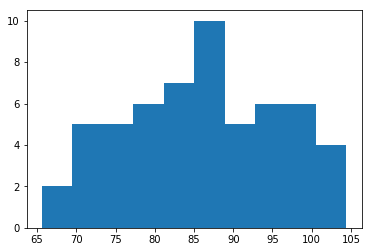

In [13]:
plt.hist(X['hsa03060.mean'])

In [ ]:
from sklearn.model_selection import train_test_split

random_state = [100, 122, 200, 300, 368, 400, 500, 600, 700, 22]
no_band_train_acc = []
no_band_test_acc = []

for i in random_state :
    
    train_df, test_df = train_test_split(no_band_final, test_size=0.2, random_state= i)
    
    X_train = train_df.drop('Weight_loss_band', axis=1)
    Y_train = train_df['Weight_loss_band']  
    
    X_test  = test_df.drop('Weight_loss_band', axis=1)
    Y_test = test_df['Weight_loss_band']  
    
    
    clf = svm.SVC(kernel = 'linear')
    clf.fit(X_train, Y_train)  

    svm_train_acc = clf.score(X_train, Y_train)
    svm_test_acc = clf.score(X_test, Y_test)
    
    no_band_train_acc.append(svm_train_acc)
    no_band_test_acc.append(svm_test_acc)
    
    print('Random State: ', i)
    
    print('Training Accuracy:', svm_train_acc)
    
    print('Test Accuracy:', svm_test_acc)

print('Mean Training Accuracy:', mean(no_band_train_acc)) 
print('Mean Test Accuracy:', mean(no_band_test_acc)) 

In [24]:
# Recursive Feature Elimination
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn import metrics



# create a base classifier used to evaluate a subset of attributes
svm = SVC(C = 150, kernel = 'rbf', max_iter = 10000, gamma = 'scale')

svm_features_included = []
svm_scores = []

n = 1

## for i in range(len(columns)):
for i in range(len(X.columns)) :

# keep the top n features

    #svm_rfe = RFE(svm, n)
    #svm_rfe = svm_rfe.fit(X, y)

##update X dataframe to include only selected features
    #X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, svm_rfe.support_], y, test_size=0.3, random_state=32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)


## run regression
    svm.fit(X_train, y_train)

    svm_train_acc = svm.score(X_train, y_train)
    svm_test_acc = svm.score(X_test, y_test)
   
    svm_features_included.append(X.iloc[:, svm_rfe.support_].columns.values)
    svm_scores.append(svm_test_acc)

    print('Features used:', len(X_train.columns.values))
    
    print('SVM: The training accuracy is:', svm_train_acc)
    print('SVM: The testing accuracy is:', svm_test_acc)



##update n
    n += 1


Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is: 0.7058823529411765
Features used: 17
SVM: The training accuracy is: 1.0
SVM: The testing accuracy is:

In [39]:
import xgboost as xgb

# XGBoost, same API as scikit-learn
gradboost = xgb.XGBClassifier(max_depth = 10, gamma = 6, n_estimators=1000)             # instantiate
gradboost.fit(X_train, y_train)                              # fit
acc_xgboost = gradboost.score(X_test, y_test)                  # predict + evalute

print('XGBoost labeling accuracy:', str(round(acc_xgboost*100,2)),'%')


XGBoost labeling accuracy: 70.59 %
